In [1]:
# --------------------------------------------------------------
# EXTRACAO DAS INFORMACOES DO CONJUNTO DE DADOS DE LINHAS
# DE ONIBUS DE FLORIANOPOLIS 
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import glob
import time

import matplotlib.pyplot as plt

### CONSTANTES
ticks = time.time()
pd.set_option('display.max_columns', None)
CAMINHO_DIRETORIO = "dataset/"
PATTERN = "*.txt"
# - data e hora de partida
# - data e hora de chegada
# - sentido (ida, volta)
# - linha
# - código do Veículo
# - total de giros => número de passageiros que passaram na catraca dos ônibus
# - quilômetros percorridos na viagem 
# - duração da viagem

def ler_diretorio_em_dataframe(caminho: str, delimitador=None, colunas=None) -> list:
        ## Funcao responsavel por ler dados de um diretorio
        ## Recebe como parametros
        ## param caminho: caminho do diretorio para leitura
        delimitador = ";" if not delimitador else delimitador
        colunas = [] if not colunas else colunas
        return [
            pd.read_csv(nome_arquivo, delimiter=delimitador, low_memory=False, names=colunas)
            for nome_arquivo in glob.glob(caminho)
        ]

def concatenar_dataframes(lista_dataframes):
    ## Concatena lista de dataframes em um unico
    ## Retorna dataframe concatenado
    return pd.concat(lista_dataframes)

def executar_script():
    # Script que executará o restante do programa
    # Declaracao de classes
    # Lendo diretorios 
    # Colunas
    n = [
        "DataPartida",
        "HoraPartida",
        "DataChegada",
        "HoraChegada",
        "Sentido",
        "Linha",
        "CodigoVeiculo",
        "DuracaoViagem",
        "GirosCatraca",
        "KmPercorridos"
    ]
    dataframes = ler_diretorio_em_dataframe("{0}/{1}".format(CAMINHO_DIRETORIO, PATTERN), colunas=n)
    # Resultado concatenado
    resultado_concatenado = concatenar_dataframes(dataframes)
    # Retornando resultado concatenado
    return resultado_concatenado

## Leitura de arquivos do diretorio
1. Montar lista de dataframes pandas equivalente a cada mes do ano de 2019.
2. Retornar dataframe concatenado com os dados brutos

In [2]:
dados_brutos = executar_script()

## Objetivo, ter uma previsão da quantidade de quilometros que serao percorridos.

In [4]:
# 1. Analisar os dados do dataframe
# 2. Unindo data e hora partida em mesma coluna e data e hora chegada em mesma coluna
dados_analises = dados_brutos.copy()

def concatenar_data_e_hora(conteudo, coluna_data, coluna_hora):
    """
    Funcao que busca concatenar da hora retornando um datetime 
    """
    conteudo[coluna_data] = conteudo[coluna_data].apply(lambda x: x[:10].replace(" 0","").strip())
    conteudo[coluna_hora] = conteudo[coluna_hora].apply(lambda x: x[-8:].strip())
    return pd.to_datetime(conteudo[coluna_data] + " " + conteudo[coluna_hora], dayfirst=True)

def converter_tipo_coluna(conteudo, nome_da_coluna, tipo_desejado):
    """
    Funcao que converte o tipo da coluna do dado dataframe
    """
    if tipo_desejado == 'float':
       conteudo[nome_da_coluna] = conteudo[nome_da_coluna].apply(lambda x: x.replace(",","."))
       conteudo[nome_da_coluna] = conteudo[nome_da_coluna].astype(tipo_desejado)
    elif tipo_desejado in ['minutesOnly']:
       conteudo[nome_da_coluna] = pd.to_datetime(conteudo[nome_da_coluna], dayfirst=True).dt.minute
    elif tipo_desejado in ['dateOnly']:
       conteudo[nome_da_coluna] = pd.to_datetime(conteudo[nome_da_coluna], dayfirst=True).dt.date
    elif tipo_desejado in ['timeOnly']:
       conteudo[nome_da_coluna] = pd.to_datetime(conteudo[nome_da_coluna], dayfirst=True).dt.time
    else:
       conteudo[nome_da_coluna] = conteudo[nome_da_coluna].astype(tipo_desejado) 
    
    return conteudo

def gerar_tick_de_um_datetime(conteudo, nome_coluna_datetime):
    """
    Funcao que converte uma coluna de datetime gerando um tick
    """
    return conteudo[nome_coluna_datetime].apply(
        lambda x: time.mktime(x.timetuple())
    )

dados_analises['DataHoraPartida'] = concatenar_data_e_hora(dados_analises.copy(), 'DataPartida', 'HoraPartida')
dados_analises['DataHoraChegada'] = concatenar_data_e_hora(dados_analises.copy(), 'DataChegada', 'HoraChegada')
dados_analises['TicksPartida'] = gerar_tick_de_um_datetime(dados_analises, 'DataHoraPartida')
dados_analises['TicksChegada'] = gerar_tick_de_um_datetime(dados_analises, 'DataHoraChegada')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'GirosCatraca', 'int')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'KmPercorridos', 'float')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'DuracaoViagem', 'minutesOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'DataPartida', 'dateOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'HoraPartida', 'timeOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'DataChegada', 'dateOnly')
dados_analises = converter_tipo_coluna(dados_analises.copy(), 'HoraChegada', 'timeOnly')

In [5]:
# 3. Limpeza de dados 1: Retirar colunas onde a datahora partida e datahora chegada são iguais
def filtrar_informacao(conteudo, predicado):
    """
    Funcao que realizar um busca no dataframe retornando seu resultado
    """
    return conteudo.query(predicado).reset_index().drop(columns=["index"])

dados_primeiro_filtro = filtrar_informacao(dados_analises.copy(), "DataHoraPartida < DataHoraChegada")
dados_primeiro_filtro

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada
0,2019-01-31,08:01:00,2019-01-31,08:03:00,Volta,100,4409,2,0,16.30,2019-01-31 08:01:00,2019-01-31 08:03:00,1.548922e+09,1.548922e+09
1,2019-02-01,00:46:00,2019-02-01,01:28:00,Volta,100,0225,42,6,16.30,2019-02-01 00:46:00,2019-02-01 01:28:00,1.548982e+09,1.548984e+09
2,2019-02-01,01:28:00,2019-02-01,02:30:00,Volta,100,0225,2,14,16.30,2019-02-01 01:28:00,2019-02-01 02:30:00,1.548984e+09,1.548988e+09
3,2019-02-01,02:30:00,2019-02-01,03:28:00,Volta,100,0225,58,11,16.30,2019-02-01 02:30:00,2019-02-01 03:28:00,1.548988e+09,1.548992e+09
4,2019-02-01,03:28:00,2019-02-01,04:15:00,Volta,100,0225,47,0,16.30,2019-02-01 03:28:00,2019-02-01 04:15:00,1.548992e+09,1.548994e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639128,2019-04-03,16:46:00,2019-04-03,17:42:00,Volta,M941,1503,56,58,22.15,2019-04-03 16:46:00,2019-04-03 17:42:00,1.554310e+09,1.554313e+09
2639129,2019-04-02,11:47:00,2019-04-02,12:38:00,Volta,M941,1455,51,75,22.15,2019-04-02 11:47:00,2019-04-02 12:38:00,1.554206e+09,1.554209e+09
2639130,2019-04-02,16:45:00,2019-04-02,17:47:00,Volta,M941,1497,2,78,22.15,2019-04-02 16:45:00,2019-04-02 17:47:00,1.554224e+09,1.554227e+09
2639131,2019-04-01,11:46:00,2019-04-01,12:38:00,Volta,M941,1477,52,74,22.15,2019-04-01 11:46:00,2019-04-01 12:38:00,1.554119e+09,1.554122e+09


In [6]:
# 4. Limpeza de dados 2, retirando dados onde quilometros percorridos é zero e catraca maior que 0.
dados_segundo_filtro = filtrar_informacao(dados_primeiro_filtro.copy(), "~(KmPercorridos == 0.00 & GirosCatraca > 0) & ~(KmPercorridos == 0.00 & GirosCatraca == 0)") 
# dados_segundo_filtro[['GirosCatraca','KmPercorridos']].hist(bins=20, range=[2.5, 75.5])
# dados_segundo_filtro[['GirosCatraca','KmPercorridos', 'DuracaoViagem']]
# 5. Limpeza de dados 3, retirando dados onde velocidade media ultrapasse os 80km/h
dados_terceiro_filtro = filtrar_informacao(dados_segundo_filtro.copy(), "KmPercorridos / (DuracaoViagem/60) <= 80")
dados_terceiro_filtro['Dur'] = ((dados_terceiro_filtro['DataHoraChegada'] - dados_terceiro_filtro['DataHoraPartida']).dt.total_seconds()//60).astype('int')
# 6. Limpeza de dados 4, retirando duracoes erradas de viagem
dados_quarto_filtro = filtrar_informacao(dados_terceiro_filtro.copy(), "Dur == DuracaoViagem")
# 7. Limpeza de dados 5, retirando ocorrencias em que um veiculo esta em duas viagens simultaneas
dados_quinto_filtro = dados_quarto_filtro.drop_duplicates(subset=["CodigoVeiculo", "TicksPartida"])
dados_quinto_filtro

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada,Dur
0,2019-02-01,00:46:00,2019-02-01,01:28:00,Volta,100,0225,42,6,16.30,2019-02-01 00:46:00,2019-02-01 01:28:00,1.548982e+09,1.548984e+09,42
1,2019-02-01,02:30:00,2019-02-01,03:28:00,Volta,100,0225,58,11,16.30,2019-02-01 02:30:00,2019-02-01 03:28:00,1.548988e+09,1.548992e+09,58
2,2019-02-01,03:28:00,2019-02-01,04:15:00,Volta,100,0225,47,0,16.30,2019-02-01 03:28:00,2019-02-01 04:15:00,1.548992e+09,1.548994e+09,47
3,2019-01-31,00:34:00,2019-01-31,01:29:00,Volta,100,0225,55,8,16.30,2019-01-31 00:34:00,2019-01-31 01:29:00,1.548895e+09,1.548898e+09,55
4,2019-01-31,02:34:00,2019-01-31,03:28:00,Volta,100,0225,54,6,16.30,2019-01-31 02:34:00,2019-01-31 03:28:00,1.548902e+09,1.548905e+09,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330499,2019-04-03,11:49:00,2019-04-03,12:39:00,Volta,M941,1455,50,76,22.15,2019-04-03 11:49:00,2019-04-03 12:39:00,1.554292e+09,1.554295e+09,50
2330500,2019-04-03,16:46:00,2019-04-03,17:42:00,Volta,M941,1503,56,58,22.15,2019-04-03 16:46:00,2019-04-03 17:42:00,1.554310e+09,1.554313e+09,56
2330501,2019-04-02,11:47:00,2019-04-02,12:38:00,Volta,M941,1455,51,75,22.15,2019-04-02 11:47:00,2019-04-02 12:38:00,1.554206e+09,1.554209e+09,51
2330502,2019-04-01,11:46:00,2019-04-01,12:38:00,Volta,M941,1477,52,74,22.15,2019-04-01 11:46:00,2019-04-01 12:38:00,1.554119e+09,1.554122e+09,52


In [7]:
import datetime
# 8. Análise, ordernar pelo tempo 
dados_ordernados_por_tick_linha = dados_quinto_filtro.copy().sort_values(by=["Linha", "TicksPartida", "Sentido"])
dados_ordernados_por_tick_linha

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada,Dur
1559656,2018-11-02,00:35:00,2018-11-02,01:27:00,Volta,100,0247,52,9,16.30,2018-11-02 00:35:00,2018-11-02 01:27:00,1.541119e+09,1.541122e+09,52
1559659,2018-11-02,01:27:00,2018-11-02,02:18:00,Volta,100,0247,51,22,16.30,2018-11-02 01:27:00,2018-11-02 02:18:00,1.541122e+09,1.541125e+09,51
1559660,2018-11-02,02:27:00,2018-11-02,03:06:00,Volta,100,0247,39,19,16.30,2018-11-02 02:27:00,2018-11-02 03:06:00,1.541126e+09,1.541128e+09,39
1559657,2018-11-02,03:31:00,2018-11-02,04:07:00,Volta,100,0247,36,28,16.30,2018-11-02 03:31:00,2018-11-02 04:07:00,1.541129e+09,1.541132e+09,36
1559658,2018-11-02,04:27:00,2018-11-02,05:08:00,Volta,100,0247,41,6,16.30,2018-11-02 04:27:00,2018-11-02 05:08:00,1.541133e+09,1.541135e+09,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370627,2019-10-29,12:25:00,2019-10-29,13:09:00,Ida,M941,1445,44,63,20.39,2019-10-29 12:25:00,2019-10-29 13:09:00,1.572352e+09,1.572355e+09,44
1370649,2019-10-30,11:49:00,2019-10-30,12:42:00,Volta,M941,1483,53,70,22.15,2019-10-30 11:49:00,2019-10-30 12:42:00,1.572436e+09,1.572439e+09,53
1370626,2019-10-30,12:26:00,2019-10-30,13:07:00,Ida,M941,1431,41,25,20.39,2019-10-30 12:26:00,2019-10-30 13:07:00,1.572438e+09,1.572441e+09,41
1370648,2019-10-31,11:49:00,2019-10-31,12:40:00,Volta,M941,1483,51,75,22.15,2019-10-31 11:49:00,2019-10-31 12:40:00,1.572523e+09,1.572526e+09,51


## Algumas linhas possuem apenas volta, outras apenas ida e outras ida e volta.

In [12]:
# 9. Análise, ida e volta de uma linha
dados_ida = filtrar_informacao(dados_ordernados_por_tick_linha.copy(), "Sentido == 'Ida'")
dados_ida = dados_ida.rename(
    columns=dict(
        zip(
            list(dados_ida.columns), 
            ["ida_" + i for i in list(dados_ida.columns)]
        )
    )
)
dados_volta = filtrar_informacao(dados_ordernados_por_tick_linha.copy(), "Sentido == 'Volta'")
dados_volta = dados_volta.rename(
    columns=dict(
        zip(
            list(dados_volta.columns),
            ["volta_" + i for i in list(dados_volta.columns)]
        )
    )
)
# 10. Análise, exemplo de linha que não possui ida
dados_ida_por_linha = filtrar_informacao(dados_ida.copy(), "ida_Linha == '100'")
dados_ida_por_linha

,ida_DataPartida,ida_HoraPartida,ida_DataChegada,ida_HoraChegada,ida_Sentido,ida_Linha,ida_CodigoVeiculo,ida_DuracaoViagem,ida_GirosCatraca,ida_KmPercorridos,ida_DataHoraPartida,ida_DataHoraChegada,ida_TicksPartida,ida_TicksChegada,ida_Dur


In [13]:
# 11. Análise, exemplo de linha que apenas possui volta
dados_volta_por_linha = filtrar_informacao(dados_volta.copy(), "volta_Linha == '100'")
dados_volta_por_linha

,volta_DataPartida,volta_HoraPartida,volta_DataChegada,volta_HoraChegada,volta_Sentido,volta_Linha,volta_CodigoVeiculo,volta_DuracaoViagem,volta_GirosCatraca,volta_KmPercorridos,volta_DataHoraPartida,volta_DataHoraChegada,volta_TicksPartida,volta_TicksChegada,volta_Dur
0,2018-11-02,00:35:00,2018-11-02,01:27:00,Volta,100,0247,52,9,16.3,2018-11-02 00:35:00,2018-11-02 01:27:00,1.541119e+09,1.541122e+09,52
1,2018-11-02,01:27:00,2018-11-02,02:18:00,Volta,100,0247,51,22,16.3,2018-11-02 01:27:00,2018-11-02 02:18:00,1.541122e+09,1.541125e+09,51
2,2018-11-02,02:27:00,2018-11-02,03:06:00,Volta,100,0247,39,19,16.3,2018-11-02 02:27:00,2018-11-02 03:06:00,1.541126e+09,1.541128e+09,39
3,2018-11-02,03:31:00,2018-11-02,04:07:00,Volta,100,0247,36,28,16.3,2018-11-02 03:31:00,2018-11-02 04:07:00,1.541129e+09,1.541132e+09,36
4,2018-11-02,04:27:00,2018-11-02,05:08:00,Volta,100,0247,41,6,16.3,2018-11-02 04:27:00,2018-11-02 05:08:00,1.541133e+09,1.541135e+09,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,2019-11-01,00:46:00,2019-11-01,01:25:00,Volta,100,264,39,13,16.3,2019-11-01 00:46:00,2019-11-01 01:25:00,1.572569e+09,1.572572e+09,39
1587,2019-11-01,01:27:00,2019-11-01,02:08:00,Volta,100,264,41,15,16.3,2019-11-01 01:27:00,2019-11-01 02:08:00,1.572572e+09,1.572574e+09,41
1588,2019-11-01,02:32:00,2019-11-01,03:06:00,Volta,100,264,34,4,16.3,2019-11-01 02:32:00,2019-11-01 03:06:00,1.572576e+09,1.572578e+09,34
1589,2019-11-01,03:30:00,2019-11-01,04:04:00,Volta,100,264,34,7,16.3,2019-11-01 03:30:00,2019-11-01 04:04:00,1.572579e+09,1.572581e+09,34


In [17]:
# 12. Análise, avaliando capacidade total dos veiculos
capacidade_total_veiculos = dados_ordernados_por_tick_linha.groupby("Linha")["GirosCatraca"].agg('max')
capacidade_total_veiculos

Linha
100       95
101       36
104      109
109       51
110       27
        ... 
M250     111
M250V     86
M273     101
M940      73
M941      94
Name: GirosCatraca, Length: 222, dtype: int64

In [41]:
# 13. Analise, adicionando colunas de dia da semana
dados_ordernados_por_tick_linha["dia_semana_partida"] = dados_ordernados_por_tick_linha.copy()["DataHoraPartida"].dt.day_name()
dados_ordernados_por_tick_linha["dia_semana_chegada"] = dados_ordernados_por_tick_linha.copy()["DataHoraChegada"].dt.day_name()
dados_com_semana = dados_ordernados_por_tick_linha.copy()
dados_com_semana

,DataPartida,HoraPartida,DataChegada,HoraChegada,Sentido,Linha,CodigoVeiculo,DuracaoViagem,GirosCatraca,KmPercorridos,DataHoraPartida,DataHoraChegada,TicksPartida,TicksChegada,Dur,dia_semana_partida,dia_semana_chegada
1559656,2018-11-02,00:35:00,2018-11-02,01:27:00,Volta,100,0247,52,9,16.30,2018-11-02 00:35:00,2018-11-02 01:27:00,1.541119e+09,1.541122e+09,52,Friday,Friday
1559659,2018-11-02,01:27:00,2018-11-02,02:18:00,Volta,100,0247,51,22,16.30,2018-11-02 01:27:00,2018-11-02 02:18:00,1.541122e+09,1.541125e+09,51,Friday,Friday
1559660,2018-11-02,02:27:00,2018-11-02,03:06:00,Volta,100,0247,39,19,16.30,2018-11-02 02:27:00,2018-11-02 03:06:00,1.541126e+09,1.541128e+09,39,Friday,Friday
1559657,2018-11-02,03:31:00,2018-11-02,04:07:00,Volta,100,0247,36,28,16.30,2018-11-02 03:31:00,2018-11-02 04:07:00,1.541129e+09,1.541132e+09,36,Friday,Friday
1559658,2018-11-02,04:27:00,2018-11-02,05:08:00,Volta,100,0247,41,6,16.30,2018-11-02 04:27:00,2018-11-02 05:08:00,1.541133e+09,1.541135e+09,41,Friday,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370627,2019-10-29,12:25:00,2019-10-29,13:09:00,Ida,M941,1445,44,63,20.39,2019-10-29 12:25:00,2019-10-29 13:09:00,1.572352e+09,1.572355e+09,44,Tuesday,Tuesday
1370649,2019-10-30,11:49:00,2019-10-30,12:42:00,Volta,M941,1483,53,70,22.15,2019-10-30 11:49:00,2019-10-30 12:42:00,1.572436e+09,1.572439e+09,53,Wednesday,Wednesday
1370626,2019-10-30,12:26:00,2019-10-30,13:07:00,Ida,M941,1431,41,25,20.39,2019-10-30 12:26:00,2019-10-30 13:07:00,1.572438e+09,1.572441e+09,41,Wednesday,Wednesday
1370648,2019-10-31,11:49:00,2019-10-31,12:40:00,Volta,M941,1483,51,75,22.15,2019-10-31 11:49:00,2019-10-31 12:40:00,1.572523e+09,1.572526e+09,51,Thursday,Thursday


In [146]:
# 14. Analise, filtrando 
import datetime
pd.set_option('display.max_rows', 400)
dados_com_semana["DataHoraPartida120"] = pd.to_datetime(dados_com_semana["DataHoraPartida"]).dt.floor('120T')
dados_com_semana_grp = dados_com_semana.copy().groupby(["Linha","DataHoraPartida120", "dia_semana_partida", "CodigoVeiculo"], as_index=False).agg({"GirosCatraca": ["sum"], "Sentido": ["count"], "Dur": ["sum"], "KmPercorridos": ["sum"]})
dados_com_semana_grp.columns = [i.replace("sum","").replace("count","") for i in list(map(''.join, dados_com_semana_grp.columns.values))]
dados_com_semana_grp = dados_com_semana_grp.rename(columns={"Sentido": "Viagens", "Dur": "Duracao"})
dados_com_semana_grp["VelocidadeMedia"] = (dados_com_semana_grp["KmPercorridos"]/(dados_com_semana_grp["Duracao"]/60))
dados_filtrados_com_linha_100 = dados_com_semana_grp.copy()[dados_com_semana_grp['Linha'] == '100']
dados_filtrados_com_linha_100

,Linha,DataHoraPartida120,dia_semana_partida,CodigoVeiculo,GirosCatraca,Viagens,Duracao,KmPercorridos,VelocidadeMedia
0,100,2018-11-02 00:00:00,Friday,0247,31,2,103,32.6,18.990291
1,100,2018-11-02 02:00:00,Friday,0247,47,2,75,32.6,26.080000
2,100,2018-11-02 04:00:00,Friday,0247,6,1,41,16.3,23.853659
3,100,2018-11-03 00:00:00,Saturday,0287,16,2,66,32.6,29.636364
4,100,2018-11-03 02:00:00,Saturday,0287,4,2,56,32.6,34.928571
...,...,...,...,...,...,...,...,...,...
991,100,2019-10-31 02:00:00,Thursday,252,7,2,71,32.6,27.549296
992,100,2019-10-31 04:00:00,Thursday,252,4,1,31,16.3,31.548387
993,100,2019-11-01 00:00:00,Friday,264,28,2,80,32.6,24.450000
994,100,2019-11-01 02:00:00,Friday,264,11,2,68,32.6,28.764706


<Axes: xlabel='DataHoraPartida120'>

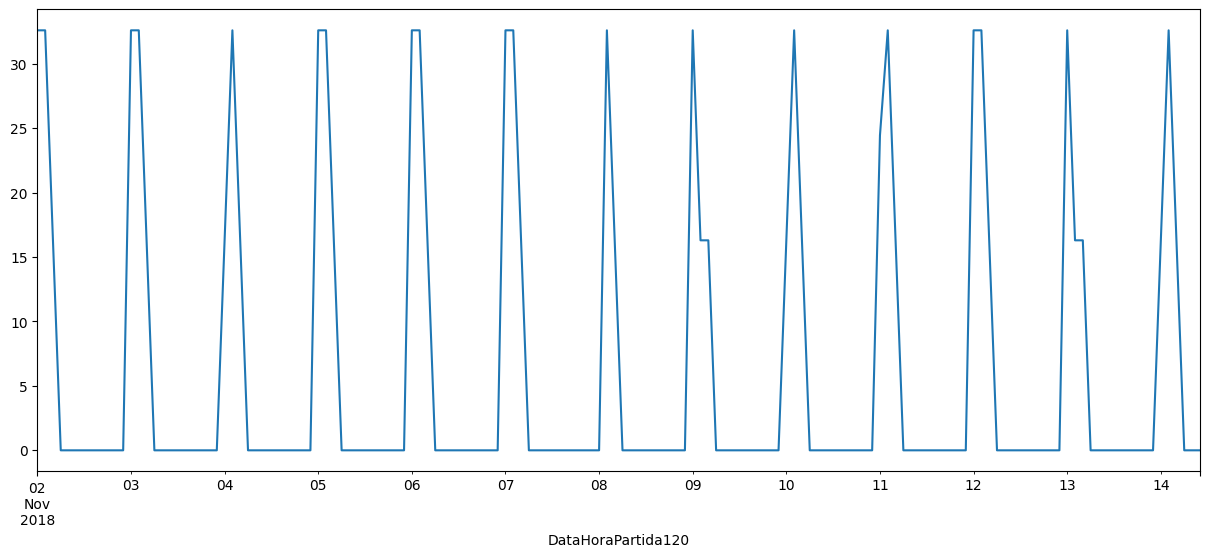

In [165]:
# 15. Filtrando para montar data hora em janelas de 2 horas e quilometros percorridos
dados_indexados = dados_filtrados_com_linha_100.copy()[['DataHoraPartida120','KmPercorridos']].set_index('DataHoraPartida120')
dados_indexados = dados_indexados['KmPercorridos'].resample('2H').mean()
dados_indexados = dados_indexados.fillna(0)
dados_indexados[:150].plot(figsize = (15, 6))

## Identificando sazonalidade dos dados

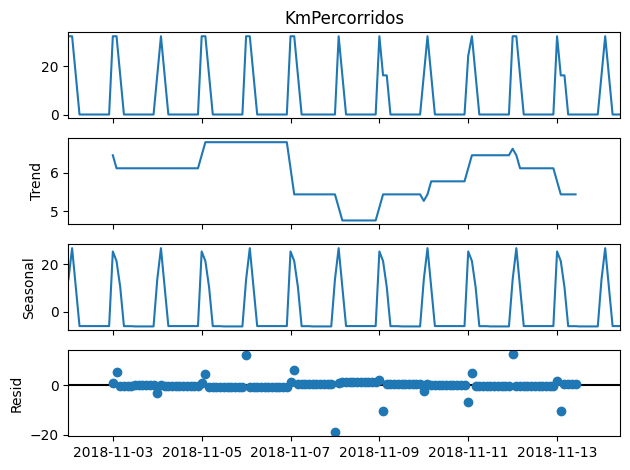

In [167]:
import statsmodels.api as sm
# rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(dados_indexados[:150], model='additive')
fig = decomposition.plot()
plt.show()